# Getting started with Gammapy

## Introduction

This is a getting started tutorial for [Gammapy](http://docs.gammapy.org/).

In this tutorial we will use the [Second Fermi-LAT Catalog of High-Energy Sources (2FHL) catalog](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2FHL/) and corresponding event list and have a look at an image and spectrum for some example sources. In detail we will cover the following topics:

#### Working with sky images
We will learn how to handle image based data with gammapy using a Fermi-LAT 2FHL example image using the following classes:

- [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
- `astropy.coordinates.SkyCoord` - See the [astropy.coordinates docs](http://astropy.readthedocs.io/en/latest/coordinates/index.html)


#### Working with source catalogs
- [gammapy.catalog.SourceCatalog](http://docs.gammapy.org/en/latest/api/gammapy.catalog.SourceCatalog.html), specifically [gammapy.catalog.SourceCatalog2FHL](http://docs.gammapy.org/en/latest/api/gammapy.catalog.SourceCatalog2FHL.html)

- `astropy.table.Table` - See the [astropy.table docs](http://astropy.readthedocs.io/en/latest/table/index.html).

#### Working with source spectra

It shows an application example for the following classes:

- [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html)

- [gammapy.spectrum.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html), specifically the [PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html) and 
[ExponentialCutoffPowerLaw3FGL](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw3FGL.html) models.

If you're not yet familiar with the listed Astropy classes, may be check out the [Astropy introduction for Gammapy users](astropy_introduction.ipynb) first.

## Setup

First, as usual with IPython notebooks and Python, we need to do some setup and imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

## Working with sky images
The central data structure to work with image based data in Gammapy is the [SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html) class. It combines the raw data with world coordinate (WCS) information, FITS I/O functionality and convenience methods, that allow easy handling, processing and plotting of image based data. 

In this section we will learn how to:

* Read sky images from FITS files
* Smooth images
* Plot images
* Cutout parts from images
* Reproject images to different WCS

The `SkyImage` class is part of the [gammapy.image](http://docs.gammapy.org/en/latest/image/index.html) submodule. So we will start by importing it from there:

In [3]:
from gammapy.image import SkyImage

As a first example, we will read a FITS file from a prepared Fermi-LAT 2FHL dataset:

In [4]:
vela_2fhl = SkyImage.read("$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_vela.fits.gz", extname='Counts')


As the FITS file `fermi_2fhl_vela.fits.gz` contains mutiple image extensions and a `SkyImage` can only represent a single image, we explicitely specify to read the extension called 'Counts'. Let's print the image to get some basic information about it:

In [5]:
print(vela_2fhl)

Name: Counts
Data shape: (180, 320)
Data type: >f8
Data unit: ct
Data mean: 2.720e-02
WCS type: ['GLON-CAR', 'GLAT-CAR']



The shape of the image is 320x180 pixel, the data unit is counts ('ct') and it is defined using a cartesian projection in galactic coordinates.

To show the actual image on the screen we can use the [SkyImage.show()](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html#gammapy.image.SkyImage.show) method:

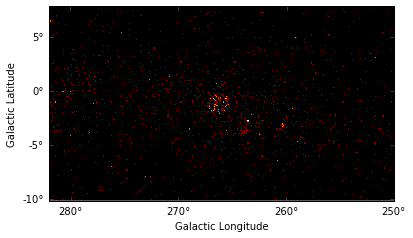

In [6]:
vela_2fhl.show()

To make the structures in the image more visible we will smooth the data using a Gausian kernel with a radius of 0.5 deg and plot the smoothed image again:

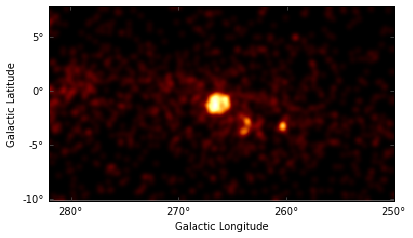

In [7]:
# smooth counts image with gaussian kernel of 0.5 deg
vela_2fhl_smoothed = vela_2fhl.smooth(kernel='gauss', radius=0.5 * u.deg)
vela_2fhl_smoothed.show()

This already looks much nicer, but still the image is rather large. As we are mostly interested in the inner part of the image, we will cut out a quadratic region of the size 9 deg x 9 deg around Vela:

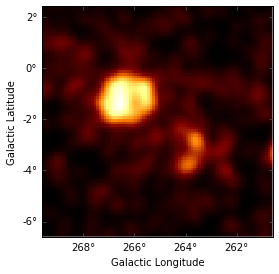

In [8]:
# define center and size of the cutout region
center = SkyCoord(265.0, -2.0, unit='deg', frame='galactic')
size = 9.0 * u.deg

vela_2fhl_cutout = vela_2fhl_smoothed.cutout(center, size)
vela_2fhl_cutout.show()

For comparison we will load a second image containing WMAP data from the same region:

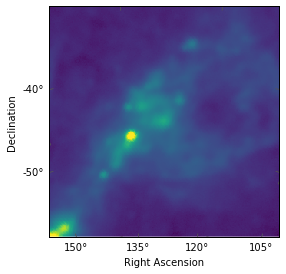

In [9]:
vela_wmap = SkyImage.read("$GAMMAPY_EXTRA/datasets/images/Vela_region_WMAP_K.fits")

# define a norm to stretch the data, so it is better visible
norm = vela_wmap.plot_norm(stretch='sqrt', max_percent=99.9)
vela_wmap.show(cmap='viridis', norm=norm)

In order to make the structures in the data better visible we used the `plot_norm()` method, which allows to stretch the data for plotting. This is very similar to the methods that e.g. `ds9` provides. In addition we used a different colormap called 'viridis'. An overview of different colomaps can be found [here](http://matplotlib.org/examples/color/colormaps_reference.html). 

Now let's check the details of the WMAP image:

In [10]:
print(vela_wmap)

Name: None
Data shape: (300, 300)
Data type: >f4
Data unit: mK
Data mean: 1.827e+00
WCS type: ['RA---TAN', 'DEC--TAN']



As you can see it is defined using a tangential projection and ICRS coordinates, which is different from the projection used for the `vela_2fhl` image. To compare both images we have to reproject one image to the WCS of the other. This can be achieved with the [SkyImage.reproject()](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html#gammapy.image.SkyImage.reproject) method: 

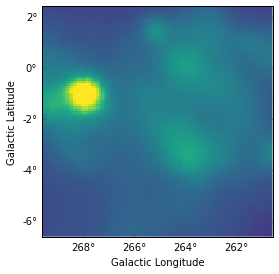

In [11]:
# reproject WMAP image
vela_wmap_reprojected = vela_wmap.reproject(vela_2fhl)

# cutout part we're interested in
vela_wmap_reprojected_cutout = vela_wmap_reprojected.cutout(center, size)
vela_wmap_reprojected_cutout.show(cmap='viridis', norm=norm)

Finally we will combine both images in single plot, by plotting WMAP contours on top of the smoothed Fermi-LAT 2FHL image:


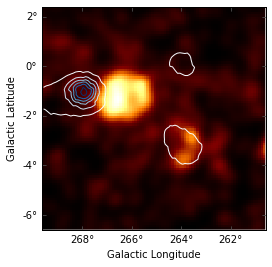

In [12]:
fig, ax, _ = vela_2fhl_cutout.plot()
ax.contour(vela_wmap_reprojected_cutout.data, cmap='Blues')

## Working with source catalogs

Gammapy provides a convenient interface to access and work with catalog based data. 

In this section we will learn how to:

* Load builtin catalogs from [gammapy.catalog](http://docs.gammapy.org/en/latest/catalog/index.html)
* Plot catalog data
* Sort and index Astropy tables
* Access data from individual sources

Let's start with importing the dictionary of available catalogs from the [gammapy.catalog](http://docs.gammapy.org/en/latest/catalog/index.html) submodule:

In [79]:
from gammapy.catalog import SourceCatalog2FHL

We choose to work with the Fermi-LAT 2FHL catalog and directly take a look at the data by accessing the `.table` attribute:

In [14]:
fermi_2fhl = source_catalogs['2fhl']
fermi_2fhl.table


Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Pos_err_68,TS,Spectral_Index,Unc_Spectral_Index,Intr_Spectral_Index_D11,Unc_Intr_Spectral_Index_D11,Intr_Spectral_Index_G12,Unc_Intr_Spectral_Index_G12,Flux50,Unc_Flux50,Energy_Flux50,Unc_Energy_Flux50,Flux50_171GeV,Unc_Flux50_171GeV [2],Sqrt_TS50_171GeV,Flux171_585GeV,Unc_Flux171_585GeV [2],Sqrt_TS171_585GeV,Flux585_2000GeV,Unc_Flux585_2000GeV [2],Sqrt_TS585_2000GeV,Npred,HEP_Energy,HEP_Prob,ROI,ASSOC,ASSOC_PROB_BAY,ASSOC_PROB_LR,CLASS,Redshift,NuPeak_obs,3FGL_Name,1FHL_Name,TeVCat_Name
str18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,str25,float32,float32,str8,float32,float32,str18,str18,str18
2FHL J0008.1+4709,2.0437,47.1642,115.339,-15.0688,0.061114,28.64,6.24,2.75,3.96,3.19,2.16,4.21,1.23e-11,6.71e-12,1.21e-12,6.71e-13,3.36344e-12,-1.53668e-12 .. 2.16095e-12,5.35354,4.34947e-18,nan .. 4.75389e-12,0.0,8.44871e-18,nan .. 7.29101e-12,0.0,4.0,68.15,0.99,1,MG4 J000800+4712,0.99722,0.834827,bll,2.1,2.51188e+15,3FGL J0008.0+4713,1FHL J0007.7+4709,
2FHL J0009.3+5031,2.3435,50.5217,116.124,-11.7932,0.0454392,53.97,5.08,1.66,nan,nan,nan,nan,1.91e-11,7.82e-12,2.03e-12,8.79e-13,8.36282e-12,-2.98962e-12 .. 3.89512e-12,7.35132,2.91458e-17,nan .. 5.10003e-12,0.0,3.50875e-16,nan .. 4.87458e-12,0.0,6.4,72.76,1.0,1,NVSS J000922+503028,0.999724,0.734808,bll,0.0,1.41254e+15,3FGL J0009.3+5030,1FHL J0009.2+5032,
2FHL J0018.5+2947,4.6355,29.7879,114.463,-32.5424,0.0370936,30.89,2.58,0.99,2.41,1.04,2.4,1.04,1.06e-11,6.15e-12,2.05e-12,1.72e-12,9.65438e-12,-5.55342e-12 .. 5.55342e-12,5.76579,1.179e-15,nan .. 5.37865e-12,0.0,1.60465e-16,nan .. 6.12008e-12,0.0,3.0,127.32,1.0,3,RBS 0042,0.999868,0.978522,bll,0.1,5.91561e+16,3FGL J0018.4+2947,1FHL J0018.6+2946,
2FHL J0022.0+0006,5.5001,0.1059,107.172,-61.8618,0.0511852,29.96,1.86,0.57,0.95,0.72,0.88,0.71,1.97e-11,9.56e-12,6.86e-12,5.29e-12,1.61197e-11,-7.17255e-12 .. 9.95349e-12,5.3822,3.63922e-12,-4.38636e-12 .. 4.38636e-12,1.38539,8.42356e-16,nan .. 7.3424e-12,0.0,4.8,180.13,0.86,2,5BZGJ0022+0006,0.99928,0.900089,bll-g,0.306,4.31519e+16,,,
2FHL J0033.6-1921,8.4115,-19.3575,94.28,-81.2224,0.0348384,148.31,3.32,0.69,2.56,0.88,2.33,0.92,5.46e-11,1.5e-11,7.62e-12,2.69e-12,4.00161e-11,-1.01615e-11 .. 1.22378e-11,12.1725,2.13901e-12,nan .. 8.25812e-12,0.907958,2.43955e-17,nan .. 6.84226e-12,0.0,13.8,170.01,0.99,2,KUV 00311-1938,0.999759,0.981424,bll,0.61,8.31764e+15,3FGL J0033.6-1921,1FHL J0033.6-1921,TeV J0033-1921
2FHL J0035.8+5949,8.9625,59.8312,120.972,-2.98122,0.0316026,402.4,2.23,0.21,nan,nan,nan,nan,1.25e-10,1.9e-11,3.11e-11,7.23e-12,9.42294e-11,-1.52566e-11 .. 1.71572e-11,17.3124,2.66991e-11,-7.62818e-12 .. 9.45084e-12,10.3909,3.72609e-16,nan .. 4.67444e-12,0.0,46.5,247.62,0.96,4,1ES 0033+595,0.999958,0.992868,bll,0.0,1.31826e+17,3FGL J0035.9+5949,1FHL J0035.9+5950,TeV J0035+5950
2FHL J0040.3+4049,10.0949,40.8315,120.676,-21.9918,0.0355148,26.76,2.12,0.81,nan,nan,nan,nan,1.05e-11,6.3e-12,2.84e-12,2.67e-12,7.41577e-12,-4.0778e-12 .. 6.45182e-12,4.95442,3.00308e-12,-2.31775e-12 .. 4.46644e-12,1.70835,4.73166e-16,nan .. 5.79809e-12,0.0,3.2,258.77,0.85,3,B3 0037+405,0.998738,0.9347,bcu I,0.0,1.0,3FGL J0040.3+4049,1FHL J0040.3+4049,
2FHL J0043.9+3424,10.9755,34.4109,121.164,-28.435,0.0592417,39.5,4.57,1.61,3.46,1.85,2.95,1.91,1.83e-11,8.24e-12,2.03e-12,9.93e-13,9.65762e-12,-4.31687e-12 .. 4.31687e-12,6.31152,8.75861e-17,nan .. 5.24335e-12,0.0,9.43812e-16,nan .. 5.68787e-12,0.0,5.4,109.97,0.9,3,GB6 J0043+3426,0.998594,0.838844,fsrq,0.966,6.45655e+13,3FGL J0043.8+3425,1FHL J0043.7+3425,
2FHL J0045.2+2127,11.3161,21.4555,121.017,-41.3933,0.0378046,110.43,3.07,0.64,nan,nan,nan,nan,4.14e-11,1.26e-11,6.29e-12,2.45e-12,3.11532e-11,-8.93008e-12 .. 1.10103e-11,10.2404,2.99712e-12,-3.03054e-12 .. 3.03054e-12,2.7089,4.68348e-17,nan .. 6.42314e-12,0.0,11.4,246.75,0.99,5,GB6 J0045+2127,0.99961,

Now we will use the catalog data to create an index vs. flux plot, which corresponds to Fig. 3 in the [Fermi-LAT 2FHL paper](https://arxiv.org/pdf/1508.04449.pdf).

In [77]:
# define galatic and extra galactic source classes
class_galactic = ['bin', 'hmb', 'psr', 'pwn', 'sfr', 'snr', 'spp']
class_extra_galactic = ['agn', 'bll', 'fsrq', 'gal', 'rdg']
class_unkown = ['unk']


# create masks
galactic = np.array([cls in class_galactic for cls in fermi_2fhl.table['CLASS']])
extra_galactic = np.array([cls in class_extra_galactic for cls in fermi_2fhl.table['CLASS']])
unknown = np.array([cls in class_unkown for cls in fermi_2fhl.table['CLASS']])

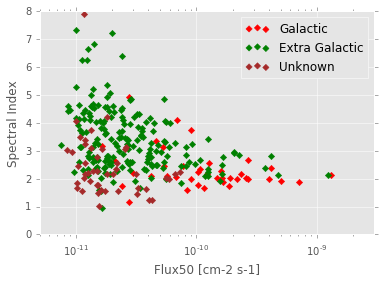

In [76]:
# access index and flux data from the catalog
index = fermi_2fhl.table['Spectral_Index']
flux = fermi_2fhl.table['Flux50']

# plot data
plt.scatter(flux[galactic], index[galactic], color='r', marker='D', label='Galactic')
plt.scatter(flux[extra_galactic], index[extra_galactic], color='g', marker='D', label='Extra Galactic')
plt.scatter(flux[unknown], index[unknown], color='brown', marker='D', label='Unknown')

plt.semilogx()
plt.xlim(0.5E-11, 3E-9)
plt.ylim(0, 8)
plt.xlabel('Flux50 [cm-2 s-1]')
plt.ylabel('Spectral Index')
plt.legend()

Now we sort the underlying table by `TS` to find the top 5 most significant sources:

In [15]:
# sort table by TS
fermi_2fhl.table.sort('TS')

# invert the order to find the highest values and take the top 5 
top_five_TS_2fhl = fermi_2fhl.table[::-1][:5]

# print the top five significant sources
top_five_TS_2fhl[['Source_Name', 'ASSOC', 'CLASS']].pprint()

   Source_Name       ASSOC     CLASS
----------------- ------------ -----
2FHL J1104.4+3812      Mkn 421   bll
2FHL J0534.5+2201         Crab   pwn
2FHL J1653.9+3945      Mkn 501   bll
2FHL J1555.7+1111  PG 1553+113   bll
2FHL J2158.8-3013 PKS 2155-304   bll


If you are interested in the data of an individual source you can access the information from catalog using the name of the source or any alias source name that is defined in the catalog:

In [78]:
mkn_421_2fhl = fermi_2fhl['2FHL J1104.4+3812']

# or use any alias source name that is defined in the catalog
mkn_421_2fhl = fermi_2fhl['Mkn 421']
print(mkn_421_2fhl.data['TS'])

5600.98


## Working with source spectra

In this section we will learn how to:

* Plot spectral models
* Computing integral fluxes
* 

In [16]:
crab_2fhl = fermi_2fhl['2FHL J0534.5+2201'] # Crab nebula


In [17]:
source.flux_points.table[['e_min', 'e_max', 'dnde']]

NameError: name 'source' is not defined

In [ ]:
energy_range = [50 * u.GeV, 1 * u.TeV]
source.flux_points.plot()
source.spectral_model.plot(energy_range=[40, 4000] * u.GeV, energy_power=0)

## Exercises

* Sky images: add a marker and circle at the Vela pulsar position
* Sky images: make the combined plot nicer, by trying to modify the contour levels and using different colormaps
* Sky images: find maximum brightness location in WMAP image. Try to identify the source.
* Source catalog: load PKS 2155-304 and plot it's spectrum
* Event list: make a counts energy spectrum for some region or source
* Spectrum: overplot 3FGL & 2FHL spectrum for some source
* Lightcurve: Find time of maximum flux
* Lightcurve: restrict to sub time range
* Lightcurve: compute variability via `f_var` for a steady and a variable source

## What next?

This was a quick introduction to some of the high-level classes in Astropy and Gammapy.

* To learn more about those classes, go to the API docs (links are in the introduction at the top).
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](http://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list.